In [5]:
suppressPackageStartupMessages({
  library(cowplot)
  library(dataorganizer)
  library(ggplot2)
  library(ggrastr)

  devtools::load_all()
})

suppressMessages({
  load_arial_font()
})

ℹ Loading cellAdmixNotebooks


In [2]:
# load the spatial data
data <- prepare_brain_tx_and_meta()
meta <- data[[1]]

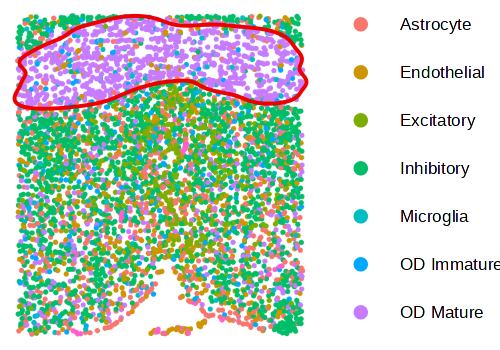

In [7]:
options(repr.plot.width = 2.5, repr.plot.height = 1.75, repr.plot.res = 200)

## make plot with cell types and region annotations
spatial_meta_a1 <- meta[meta$Animal_ID==1 & meta$Bregma==.21,]
# ggplot(spatial_meta_a1,aes(x=x,y=y,color=spat_clust)) +
#   geom_point()
spatial_meta_a1_sub <- spatial_meta_a1[spatial_meta_a1$spat_clust==3,]
# ensuring no cells far away from ACA are in the cluster because that can mess up the hull
spatial_meta_a1_sub <- spatial_meta_a1_sub[spatial_meta_a1_sub$y>3250,]

conf="3%"

emb <- spatial_meta_a1_sub
emb <- emb[,c('x','y')]
kd <- ks::kde(emb, compute.cont=TRUE)

lcn <- kd %$% contourLines(x=eval.points[[1]], y=eval.points[[2]], z=estimate, levels=cont[conf]) %>%
.[[1]] %>% data.frame() %>% cbind(z=1)
cn <- geom_path(aes(x, y), data=lcn, color='red2')

p <- ggplot(spatial_meta_a1,aes(x=x,y=y,color=cell_type)) +
  geom_point_rast(size=.001) +
  guides(colour = guide_legend(override.aes = list(size=3)))

p <- p + cn

p <- p +
  labs(color='Cell type') +
  theme_void() +
  legend_mod +
  theme(text = element_text(family = font_choice),
       legend.text=element_text(size=6),
       legend.title=element_text(size=8))
p

In [8]:
# getting height width ratio to keep aspect ratio accurate in the pdf
x_diff <- max(spatial_meta_a1$x) - min(spatial_meta_a1$x)
y_diff <- max(spatial_meta_a1$y) - min(spatial_meta_a1$y)
aspect_ratio <- y_diff / x_diff

width_plot <- 2
height_plot <- aspect_ratio * width_plot
print(height_plot)

[1] 1.996461


In [9]:
pdf(OutputPath('brain_ACA_region.pdf'), useDingbats=FALSE, width=width_plot, height=height_plot)
p + theme(legend.position="none")
dev.off()

png 
  2

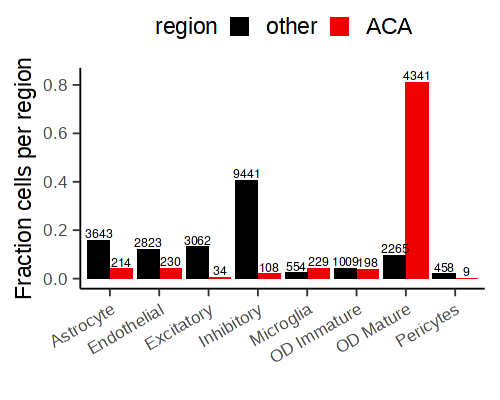

In [10]:
options(repr.plot.width = 2.5, repr.plot.height = 2, repr.plot.res = 200)

## compute counts of each cell type in each region
cell_annot_aca <- meta[meta$spat_clust==3,]
ct_counts_stemta <- table(cell_annot_aca$cell_type)
cell_annot_other <- meta[meta$spat_clust!=3,]
ct_counts_other <- table(cell_annot_other$cell_type)

ct_counts_stemta['Ependymal'] <- 0
ct_counts_stemta <- ct_counts_stemta[names(ct_counts_other)]

c1 <- c(ct_counts_stemta,ct_counts_other)
c2 <- c(names(ct_counts_stemta),names(ct_counts_other))
c3 <- c(rep('ACA',length(ct_counts_stemta)),rep('other',length(ct_counts_other)))
ct_fracs <- cbind.data.frame(c1,c2,c3)
colnames(ct_fracs) <- c('counts','cell_type','region')
ct_fracs$cell_type <- as.factor(ct_fracs$cell_type)
ct_fracs$region <- factor(ct_fracs$region,levels=c('other','ACA'))
ct_fracs2 <- ct_fracs

total_counts <- table(meta$spat_clust)
ndx1 <- which(names(total_counts)==3)
ndx2 <- which(names(total_counts)!=4)
total_counts1 <- total_counts[names(total_counts)==3]
total_counts2 <- sum(total_counts[names(total_counts)!=3])
total_counts <- c(total_counts1,total_counts2)
names(total_counts) <- c('ACA','other')

match_ndx <- match(ct_fracs2$region,names(total_counts))
ct_fracs2$total_counts <- total_counts[match_ndx]
ct_fracs2$fracs <- ct_fracs2$counts / ct_fracs2$total_counts
p <- ggplot(ct_fracs2,aes(x=cell_type,y=fracs,fill=region)) +
  geom_bar(position = "dodge", stat = "identity") +
  geom_text(aes(label=counts), position=position_dodge(width=0.9), vjust=-0.25, size=(3*geom_text_size)/4) +
  ylim(c(0,max(ct_fracs2$fracs)+.02)) +
  xlab('') +
  ylab('Fraction cells per region') +
  theme_classic(base_line_size = gg_line_thickness) +
  scale_fill_manual(breaks = c('other','ACA'),values = c('black','red2')) +
  p_theme +
  theme(axis.text.x = element_text(angle = 30, vjust = 1, hjust=1),
       legend.key.size = unit(8, 'pt'),
        legend.key.height = unit(8, 'pt'),
        legend.key.width = unit(8, 'pt'),
        legend.title=element_text(size=8),
        legend.text=element_text(size=8),
       axis.title.x = element_text(size = 5),
       legend.position="top",
       legend.box="vertical", legend.margin=margin())

p


In [11]:
pdf(OutputPath('brain_cell_counts.pdf'), useDingbats=FALSE, width=2.5, height=2)
p
dev.off()

png 
  2